In [1]:
import io
import pandas as pd
import requests
import matplotlib.pyplot as plt
import zipfile
import gzip
%matplotlib inline

### Potential sources

 - https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
 - https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-11.xls
 - https://www.who.int/westernpacific/our-work/resources/data
 - https://hiip.wpro.who.int/portal/default.aspx
 - https://coronavirus.jhu.edu/
 - https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6
 - https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series 
 - https://ourworldindata.org/coronavirus
 - https://www.worldometers.info/coronavirus/

### Country Populations

https://data.worldbank.org/indicator/SP.POP.TOTL

In [2]:
r = requests.get("http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv", stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
f = z.open('API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv')
pop = pd.read_csv(f, header=2)

In [3]:
pop = pop.rename(columns={'Country Name': 'country', 'Country Code': 'ccode', '2018': 'pop_count'})
pop['country'] = pop['country'].str.upper()
pop = pop.loc[:,['country', 'ccode', 'pop_count']]
pop.sample(5)

,country,ccode,pop_count
52,CZECH REPUBLIC,CZE,10625695.0
220,SLOVENIA,SVN,2067372.0
94,"HONG KONG SAR, CHINA",HKG,7451000.0
219,SLOVAK REPUBLIC,SVK,5447011.0
198,QATAR,QAT,2781677.0


### COVID-19 Case Count

https://experience.arcgis.com/experience/685d0ace521648f8a5beeeee1b9125cd

In [4]:
url = "https://services.arcgis.com/5T5nSi527N4F7luB/arcgis/rest/services/COVID_19_HistoricCasesByCountry(pt)View/FeatureServer/0/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2Ccum_conf%2CDateOfDataEntry%2CADM0_NAME&orderByFields=DateOfDataEntry%20asc&resultOffset=0&resultRecordCount=2000&cacheHint=true"
raw = requests.get(url, headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:73.0) Gecko/20100101 Firefox/73.0",
    #"Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3",
    "Cache-Control": "max-age=0",
})

In [5]:
raw.json()['features'][:1]

[{'attributes': {'OBJECTID': 969,
   'cum_conf': 1,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'JAPAN'}}]

In [6]:
data = pd.json_normalize(raw.json(), record_path='features')
data = data.rename(columns={'attributes.OBJECTID':'id', 'attributes.ADM0_NAME': 'country',
                            'attributes.cum_conf':'cumsum', 'attributes.DateOfDataEntry':'unixtime'})
data['date'] = pd.to_datetime(data['unixtime'], origin='unix', unit='ms')
data.sample(5)

,id,cumsum,unixtime,country,date
382,775,3,1581379200000,INDIA,2020-02-11
690,1556,2,1582329600000,RUSSIAN FEDERATION,2020-02-22
1482,487,1,1583539200000,DOMINICAN REPUBLIC,2020-03-07
138,1703,1,1580515200000,SPAIN,2020-02-01
321,2077,13,1581120000000,VIET NAM,2020-02-08


### Merged data

In [7]:
keys = ['BELGIUM', 'NETHERLANDS', 'LUXEMBOURG', 'FRANCE', 'ITALY', 'GERMANY', 'CHINA']

In [8]:
merged = pop.merge(data, on='country', how='right')
merged['normalized'] = 1e5*merged['cumsum']/merged['pop_count']
merged.sample(5)

,country,ccode,pop_count,id,cumsum,unixtime,date,normalized
176,BELGIUM,BEL,11422068.0,187,1,1580947200000,2020-02-06,0.008755
645,FRANCE,FRA,66987244.0,626,12,1582588800000,2020-02-25,0.017914
511,ECUADOR,ECU,17084357.0,497,7,1583366400000,2020-03-05,0.040973
1187,NORTH MACEDONIA,MKD,2082958.0,1315,4,1583712000000,2020-03-09,0.192035
60,UNITED ARAB EMIRATES,ARE,9630959.0,1953,13,1582675200000,2020-02-26,0.134981


In [9]:
data.to_csv('covid19_{:%Y%m%d}.csv'.format(pd.Timestamp.now()))

In [10]:
cross = merged.pivot_table(index='date', columns='country', values='cumsum')
cross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-08,169.0,188.0,2.0,939.0,5883.0,847.0,80859.0
2020-03-09,200.0,265.0,2.0,1116.0,7375.0,1112.0,80904.0
2020-03-10,239.0,321.0,5.0,1402.0,9172.0,1139.0,80924.0
2020-03-11,267.0,382.0,5.0,1774.0,10149.0,1296.0,80955.0
2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
ncross = merged.pivot_table(index='date', columns='country', values='normalized')
ncross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-08,1.479592,1.091056,0.329095,1.401759,9.735024,1.021369,5.805792
2020-03-09,1.750996,1.537924,0.329095,1.665989,12.203944,1.340924,5.809023
2020-03-10,2.092441,1.862920,0.822736,2.092936,15.177570,1.373482,5.810459
2020-03-11,2.337580,2.216932,0.822736,2.648265,16.794282,1.562803,5.812684
2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trends

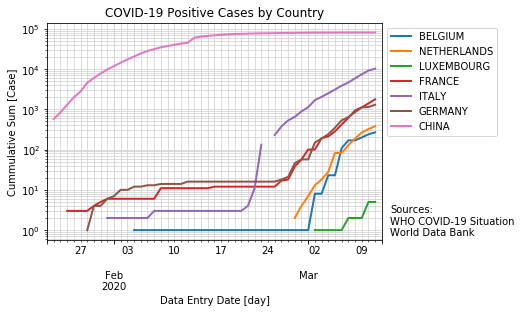

In [12]:
axe = cross[keys].plot(logy=True, linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Cummulative Sum [Case]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

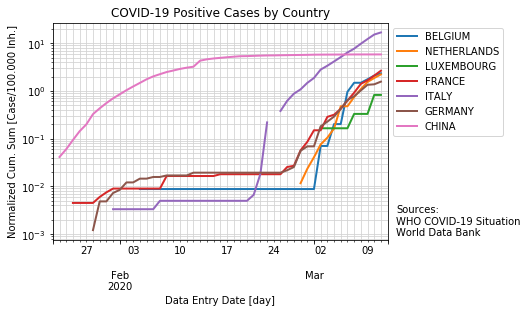

In [13]:
axe = ncross[keys].plot(logy=True, linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

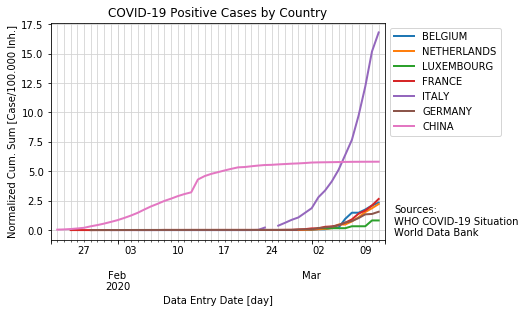

In [14]:
axe = ncross.loc[:,keys].plot(linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

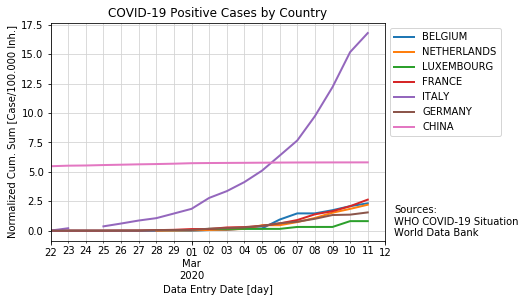

In [15]:
axe = ncross.loc['2020-02-22':,keys].plot(linewidth=2)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

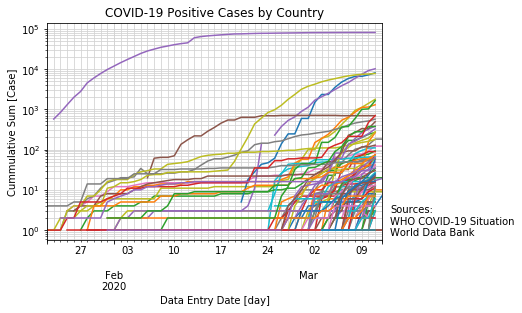

In [16]:
axe = cross.plot(logy=True)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Cummulative Sum [Case]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()

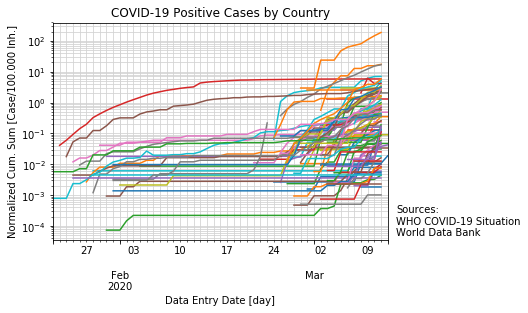

In [17]:
axe = ncross.plot(logy=True)
axe.set_title("COVID-19 Positive Cases by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Normalized Cum. Sum [Case/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()

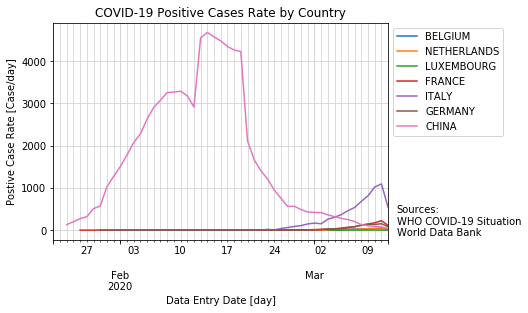

In [18]:
axe = cross.rolling(7, min_periods=1, center=False).mean().diff()[keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

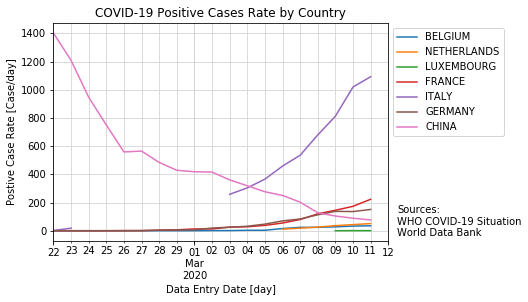

In [19]:
axe = cross.rolling(7, min_periods=7, center=False).mean().diff().loc['2020-02-22':,keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

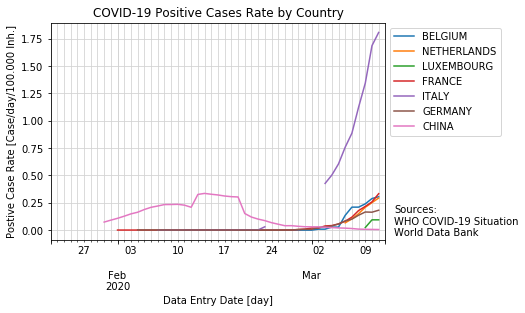

In [20]:
axe = ncross.rolling(7, min_periods=7, center=False).mean().diff()[keys].plot()
axe.set_title("COVID-19 Positive Cases Rate by Country")
axe.set_xlabel("Data Entry Date [day]")
axe.set_ylabel("Postive Case Rate [Case/day/100.000 Inh.]")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")